In [1]:
import cv2 as cv

In [2]:
import numpy as np

import personal_TEST
# import importlib

def gen_data():

    import itertools
    import numpy as np
    
    cube = (np.array(list(itertools.product([0, 1], repeat=3))) - 0.5)*2
    rotation_matrix = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])
    cube_rot = np.dot(cube, rotation_matrix)
    cube_cam = cube + 5
    cube_rot_cam = cube_rot + 5

    # Intrinsic matrix
    fx = 1000.0  # Focal length in the x-direction (horizontal)
    fy = 1000.0  # Focal length in the y-direction (vertical)
    cx = 640.0   # X-coordinate of the principal point (usually the image center)
    cy = 480.0   # Y-coordinate of the principal point (usually the image center)
    K = np.array([[fx, 0, cx],
                [0, fy, cy],
                [0, 0, 1]])

    def cam_2_pixels(cube_cam, K):
        uvw_cube = (K@cube_cam.T).T
        uv = (uvw_cube/uvw_cube[:,2].reshape(-1,1))[:,:2]
        return uv

    uv_cube = cam_2_pixels(cube_cam, K)
    uv_rot_cube = cam_2_pixels(cube_rot_cam, K)

    return cube_cam, cube, uv_cube, cube_rot_cam, cube_rot, uv_rot_cube, K

########## the whole thing without plots

# gen data
cube_cam, cube, uv_cube, cube_rot_cam, cube_rot, uv_rot_cube, K = gen_data()
_, Xworld, _, Xcam, _, uv_rot_cube, A = cube_cam, cube, uv_cube, cube_rot_cam, cube_rot, uv_rot_cube, K
A = np.hstack((A, np.zeros((3,1))))

# load points
ET = personal_TEST.EPnPTest()
ET.load_custom_points(Xworld, Xcam, uv_rot_cube, uv_cube, A)

# apply EPnP:                                                           only requires Xworld, Ximg_pix, A
error, Rt, Cc, Xc = ET.apply_EPnP(plot=False)
error_gauss, Rt_gauss, Cc_gauss, Xc_gauss = ET.apply_EPnP_Gauss(plot=False)

# compare points to ground truth

P = K@Rt            # create projection matrix from given intrinsic K and extrinsic Rt
Xw = cube           # let the world (unaltered) points be the points to project
Xw_h = np.concatenate((Xw.reshape((8, 3)), np.array([np.ones((8))]).T), axis=1) # homogenize the world points

# world2image
Urep = np.matmul(P, Xw_h.T).T
Urep[:, 0] = Urep[:, 0] / Urep[:, 2]
Urep[:, 1] = Urep[:, 1] / Urep[:, 2]

print(Urep)
print(uv_rot_cube)

print('and the third column yields depth')


[[1536.4596402  1729.96854087    4.00050341]
 [1237.66482949 1313.34731575    6.00050341]
 [1889.96854087 2083.47744155    4.00050341]
 [1473.34731575 1549.02980202    6.00050341]
 [1889.96854087 1376.4596402     4.00050341]
 [1473.34731575 1077.66482949    6.00050341]
 [2243.47744155 1729.96854087    4.00050341]
 [1709.02980202 1313.34731575    6.00050341]]
[[1536.5        1730.        ]
 [1237.66666667 1313.33333333]
 [1890.         2083.5       ]
 [1473.33333333 1549.        ]
 [1890.         1376.5       ]
 [1473.33333333 1077.66666667]
 [2243.5        1730.        ]
 [1709.         1313.33333333]]
and the third column yields depth


In [17]:
Xworld[:4].astype(np.float32), Xcam[:4].astype(np.float32)

(array([[-1., -1., -1.],
        [-1., -1.,  1.],
        [-1.,  1., -1.],
        [-1.,  1.,  1.]], dtype=float32),
 array([[3.586, 5.   , 4.   ],
        [3.586, 5.   , 6.   ],
        [5.   , 6.414, 4.   ],
        [5.   , 6.414, 6.   ]], dtype=float32))

In [ ]:
rot = np.linalg.solve(Rt[:3,:3], R.T)
rot_error = 180 - np.arccos((np.trace(rot)-1)/2)*180/np.pi

In [79]:

import cv2

all_flags = [
    'SOLVEPNP_ITERATIVE', 'SOLVEPNP_EPNP', 'SOLVEPNP_P3P', 'SOLVEPNP_DLS', 'SOLVEPNP_UPNP', 'SOLVEPNP_AP3P', 
    'SOLVEPNP_IPPE', 
    # 'SOLVEPNP_IPPE_SQUARE', 
    'SOLVEPNP_SQPNP'
]
rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])


for flag in all_flags:
    success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    # print(rotation_matrix)

    # print angular error between estimate and ground truth
    rot = np.linalg.solve(rotation_matrix_gt, rotation_matrix.T)
    print(np.trace(rot))
    if np.isclose(np.trace(rot), -1):
        trace = -1
    else:
        trace = np.trace(rot)

    rot_error = np.arccos(np.clip((trace-1)/2, -1, 1))*180/np.pi
    print(f'flag: {flag}, rot_error: {rot_error}')


3.000302064136374
flag: SOLVEPNP_ITERATIVE, rot_error: 0.0
-0.9999999999999997
flag: SOLVEPNP_EPNP, rot_error: 180.0
3.000302065671758
flag: SOLVEPNP_P3P, rot_error: 0.0
-0.9999999999999997
flag: SOLVEPNP_DLS, rot_error: 180.0
-0.9999999999999997
flag: SOLVEPNP_UPNP, rot_error: 180.0
3.0003020656698727
flag: SOLVEPNP_AP3P, rot_error: 0.0
3.000302063047643
flag: SOLVEPNP_IPPE, rot_error: 0.0
3.0003020635853046
flag: SOLVEPNP_SQPNP, rot_error: 0.0


In [80]:
# what about with the created datasets?

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 243.67it/s]


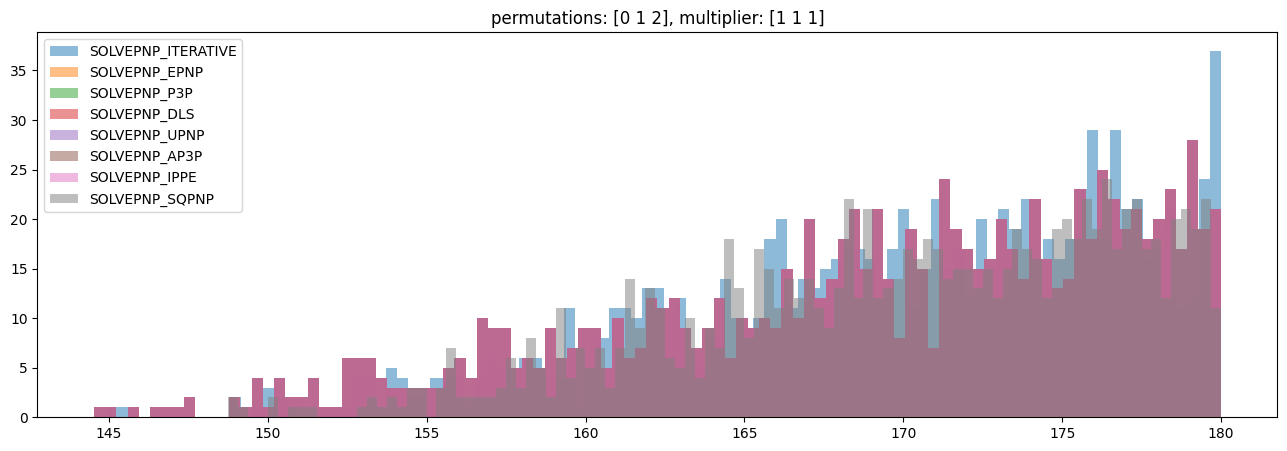

100%|██████████| 1000/1000 [00:03<00:00, 290.33it/s]


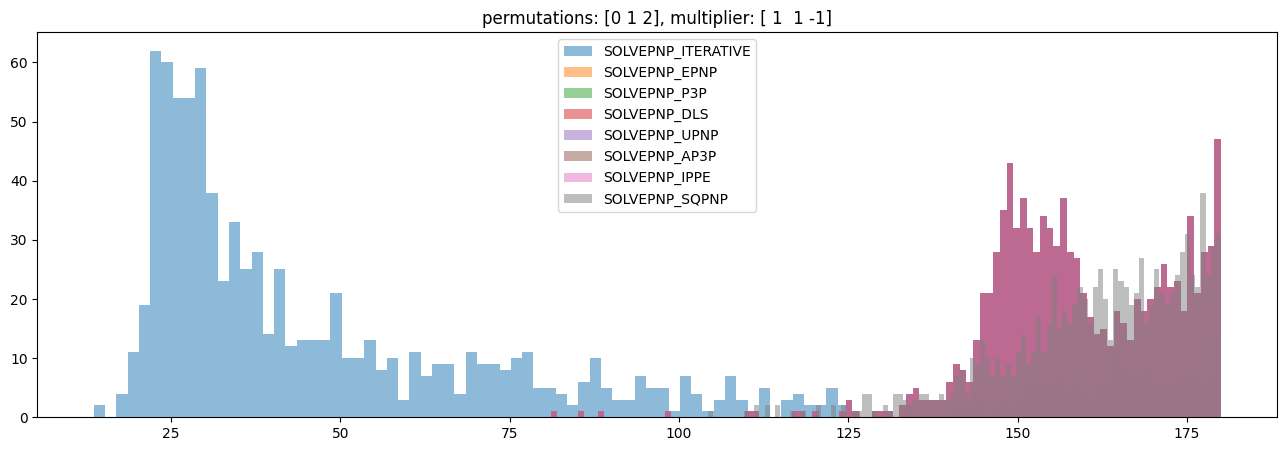

100%|██████████| 1000/1000 [00:02<00:00, 343.92it/s]


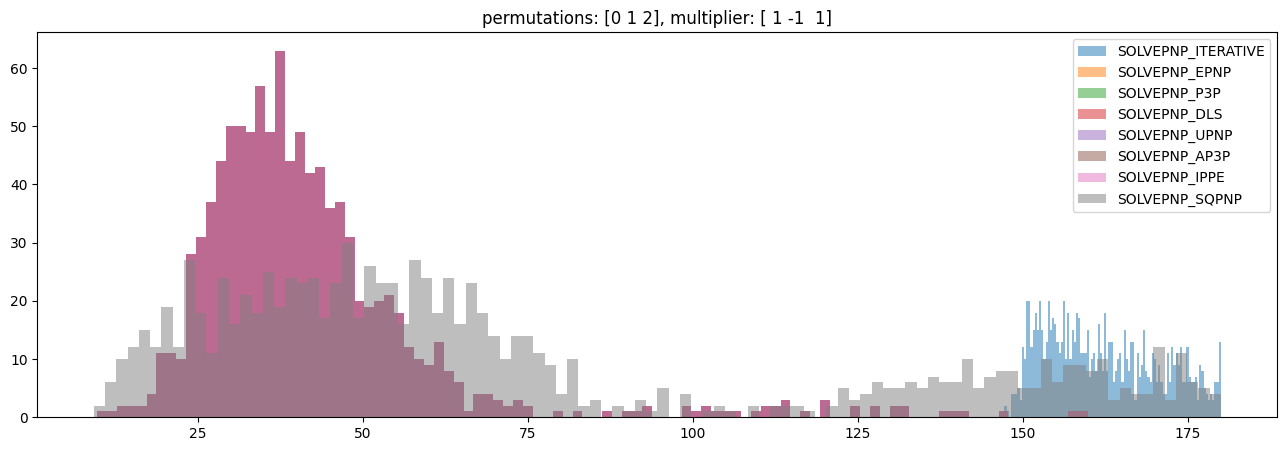

100%|██████████| 1000/1000 [00:02<00:00, 356.45it/s]


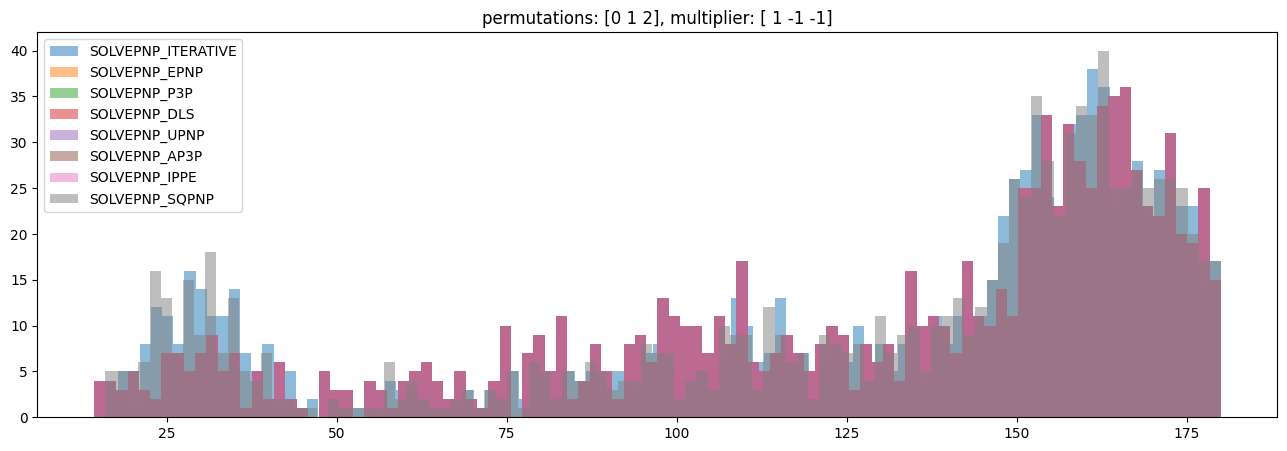

100%|██████████| 1000/1000 [00:04<00:00, 223.03it/s]


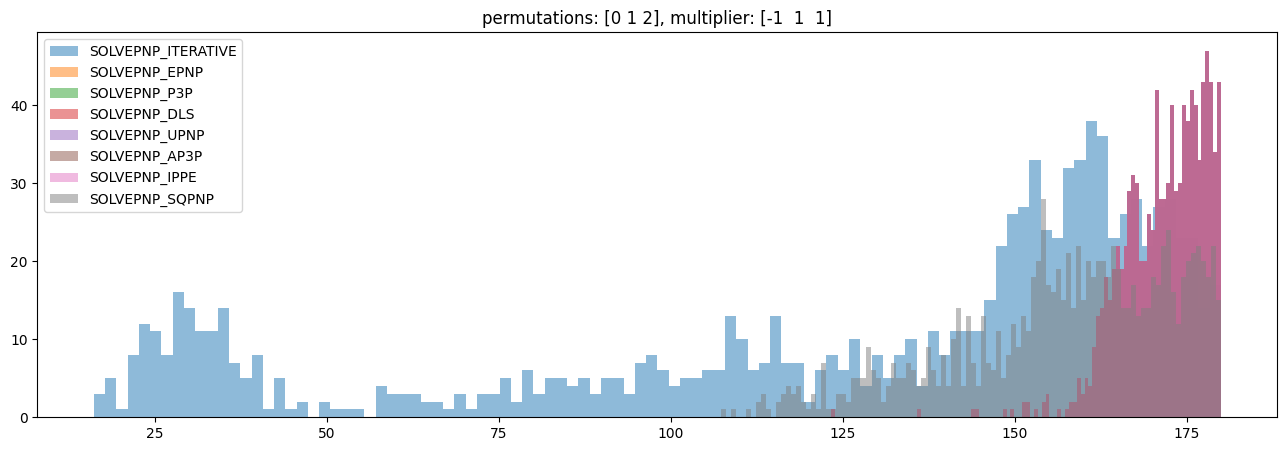

100%|██████████| 1000/1000 [00:02<00:00, 336.85it/s]


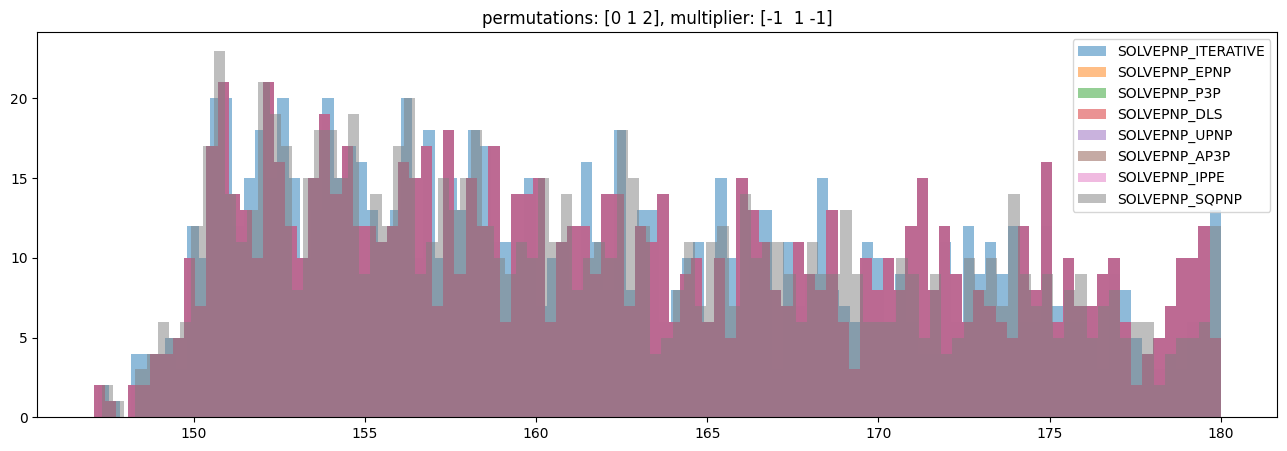

100%|██████████| 1000/1000 [00:03<00:00, 301.86it/s]


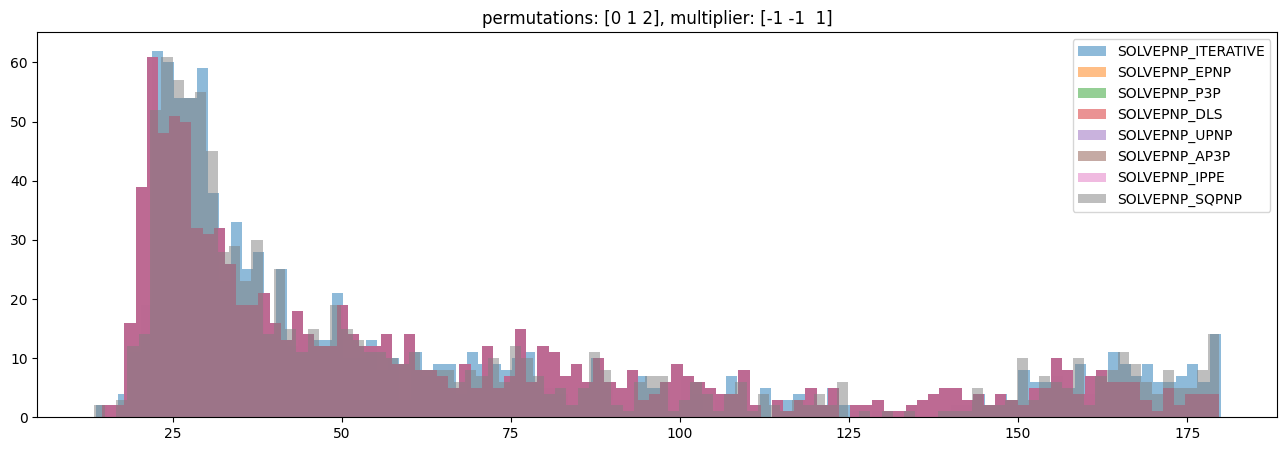

100%|██████████| 1000/1000 [00:03<00:00, 259.00it/s]


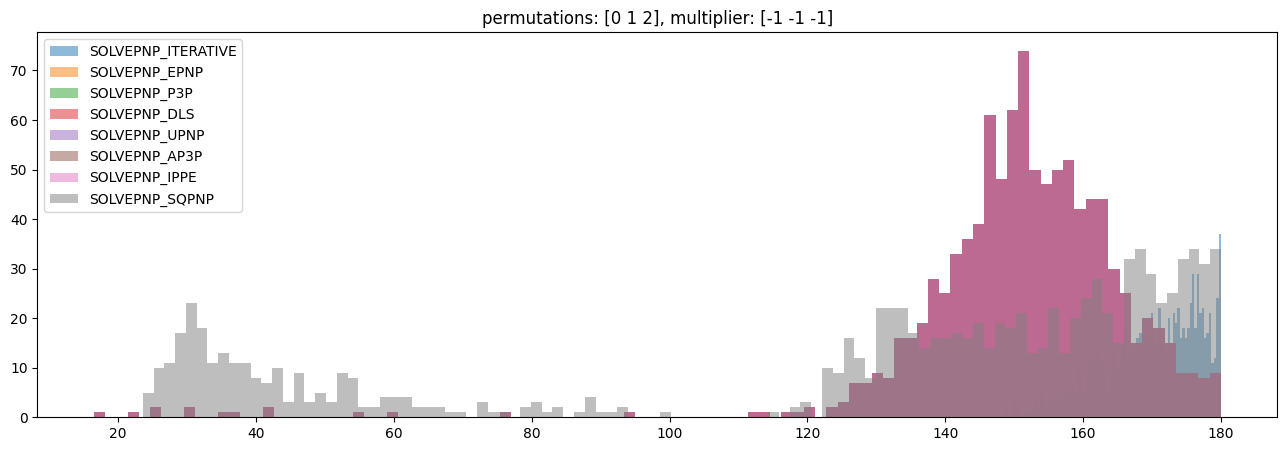

 17%|█▋        | 1/6 [00:44<03:42, 44.48s/it]

In [ ]:

# whole dataset:
import json
import numpy as np
import cv2 as cv
import cv2
import glob
import tqdm
import personal_TEST
import importlib
import numpy as np
from scipy.spatial.transform import Rotation
import itertools
multipliers = np.array(list(itertools.product([1, -1], repeat=3)))
permutations = np.array(list(itertools.permutations([0, 1, 2])))

# angular_errors = []
# l2_pts_errors = []

# p = np.array([0, 2, 1])
# m = np.array([-1, -1, 1])
json_files = glob.glob('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/*.json')

for p in tqdm.tqdm(permutations):
    for m in multipliers:
        
        angular_errors = []
        l2_pts_errors = []
        
        for json_file in tqdm.tqdm(json_files[:1000]):
            example_data = json.loads(open(json_file).read())
            # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

            base_world_pts = np.array(example_data['world_keypoints'])
            base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
            base_world_pts = base_world_pts*m

            observed_pts   = np.array(example_data['sensor_keypoints'])
            observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]


            shuffled_indices = np.random.permutation(len(observed_pts))
            # observed_pts = observed_pts[shuffled_indices]


            blender_K = np.array(example_data['intrinsic_matrix'])
            # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
            K = np.eye(3)
            R = example_data['attitude_rot']        # this is a quaternion - needs to be converted to a rotation matrix

            r = Rotation.from_quat(np.array(R))
            R = r.as_matrix()

            K = np.hstack((K, np.zeros((3,1))))
            Xworld = np.array(base_world_pts)
            Xcam = np.array(observed_pts)
            A = np.array(K)

            # load points
            # ET = personal_TEST.EPnPTest()
            # ET.load_custom_points_noplot(Xworld, Xcam, A)

            # run EPnP
            # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
            
            ########  ---------------------------------------rotation error
            all_flags = [
                'SOLVEPNP_ITERATIVE', 
                'SOLVEPNP_EPNP', 
                'SOLVEPNP_P3P', 
                'SOLVEPNP_DLS', 
                'SOLVEPNP_UPNP', 
                'SOLVEPNP_AP3P', 
                'SOLVEPNP_IPPE', 
                'SOLVEPNP_SQPNP'
            ]
            # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

            ang_error_each = []
            for flag in all_flags:
                try:
                    success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
                    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
                except:
                    pass
                # print(rotation_matrix)
                # print angular error between estimate and ground truth
                rot = np.linalg.solve(R, rotation_matrix.T)
                # print(np.trace(rot))
                if np.isclose(np.trace(rot), -1): trace = -1
                else: trace = np.trace(rot)
                rot_error = np.arccos(np.clip((trace-1)/2, -1, 1))*180/np.pi
                # print(f'flag: {flag}, rot_error: {rot_error}')
                ang_error_each.append(rot_error)
            
            angular_errors.append(ang_error_each)


        import matplotlib.pyplot as plt
        angular_errors = np.array(angular_errors)
        try:
            plt.figure(figsize=(16,5))
            plt.title('permutations: {}, multiplier: {}'.format(p, m))
            plt.hist(angular_errors[:,0], bins=100, label='SOLVEPNP_ITERATIVE', alpha=0.5);
            plt.hist(angular_errors[:,1], bins=100, label='SOLVEPNP_EPNP', alpha=0.5);
            plt.hist(angular_errors[:,2], bins=100, label='SOLVEPNP_P3P', alpha=0.5);
            plt.hist(angular_errors[:,3], bins=100, label='SOLVEPNP_DLS', alpha=0.5);
            plt.hist(angular_errors[:,4], bins=100, label='SOLVEPNP_UPNP', alpha=0.5);
            plt.hist(angular_errors[:,5], bins=100, label='SOLVEPNP_AP3P', alpha=0.5);
            plt.hist(angular_errors[:,6], bins=100, label='SOLVEPNP_IPPE', alpha=0.5);
            plt.hist(angular_errors[:,7], bins=100, label='SOLVEPNP_SQPNP', alpha=0.5);
            plt.legend()
            plt.show()
        except: pass
        

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 244.62it/s]


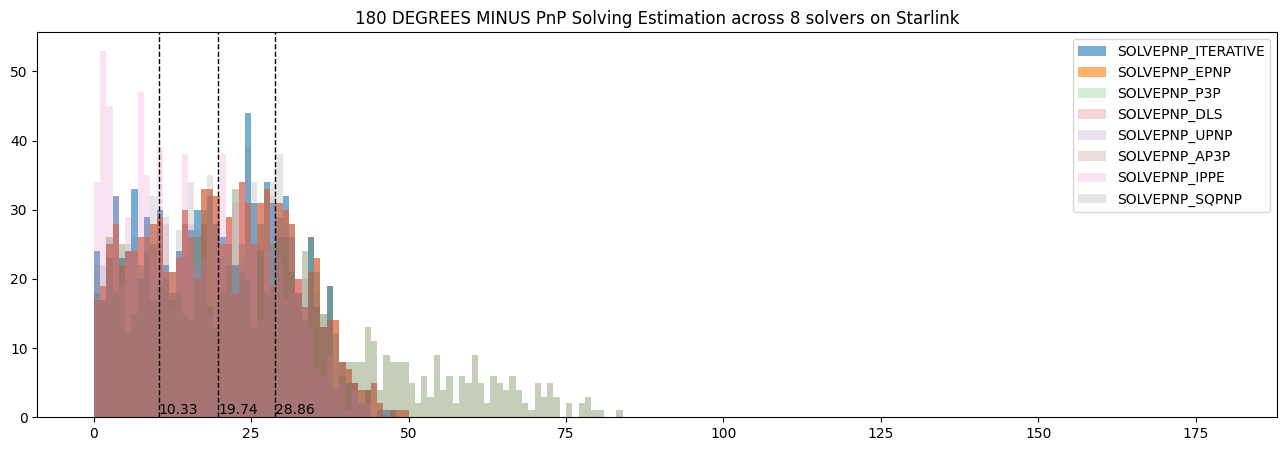

In [76]:
# whole dataset:
import json
import numpy as np
import cv2 as cv
import cv2
import glob
import tqdm
import personal_TEST
import importlib
import numpy as np
from scipy.spatial.transform import Rotation
import itertools
multipliers = np.array(list(itertools.product([1, -1], repeat=3)))
permutations = np.array(list(itertools.permutations([0, 1, 2])))

# angular_errors = []
# l2_pts_errors = []

p = np.array([2, 1, 0])
m = np.array([-1, 1, 1])
json_files = glob.glob('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/*.json')

# for p in tqdm.tqdm(permutations):
#     for m in multipliers:
        
angular_errors = []
l2_pts_errors = []
trans_errors = []

for json_file in tqdm.tqdm(json_files[:1000]):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

    # translation_pts = np.array(example_data['translation'])
    # translation_pts[[0, 1, 2]] = translation_pts[list(p)]
    # translation_pts = translation_pts*m
    # translation_pts = translation_pts*np.array([-1, 1, 1])


    shuffled_indices = np.random.permutation(len(observed_pts))
    # observed_pts = observed_pts[shuffled_indices]


    blender_K = np.array(example_data['intrinsic_matrix'])
    K = np.array([[blender_K[0,0]/blender_K[1,1], 0, 0.5], [0, 1, 0.5], [0, 0, 1]])
    # K = np.eye(3)
    R = example_data['attitude_rot']        # this is a quaternion - needs to be converted to a rotation matrix

    r = Rotation.from_quat(np.array(R))
    R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation error
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_DLS', 
        'SOLVEPNP_UPNP', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_IPPE', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each   = []
    trans_error_each = []
    for flag in all_flags:
        if flag == 'SOLVEPNP_P3P' or flag == 'SOLVEPNP_AP3P' or flag == 'SOLVEPNP_IPPE':
            success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
        else:
            success, rotation_vector, translation_vector = cv.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
        rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
        
        # trans error
        # normalize translation vector
        translation_vector = translation_vector[:,0]
        translation_vector = translation_vector/np.linalg.norm(translation_vector)
        translation_pts = translation_pts/np.linalg.norm(translation_pts)
        # print(translation_vector.shape, translation_pts.shape)
        trans_error_each.append(np.sqrt(np.sum((translation_vector - translation_pts)**2)))
        
        # print(rotation_matrix)
        # print angular error between estimate and ground truth
        rot = np.linalg.solve(R, rotation_matrix.T)
        # print(np.trace(rot))
        if np.isclose(np.trace(rot), -1): trace = -1
        else: trace = np.trace(rot)
        rot_error = 180 - np.arccos(np.clip((trace-1)/2, -1, 1))*180/np.pi
        # print(f'flag: {flag}, rot_error: {rot_error}')
        ang_error_each.append(rot_error)
    
    angular_errors.append(ang_error_each)
    trans_errors.append(trans_error_each)


import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
trans_errors = np.array(trans_errors)
try:

    # define plt bins
    bins = np.arange(0, 180, 1)

    plt.figure(figsize=(16,5))
    plt.title('180 DEGREES MINUS PnP Solving Estimation across 8 solvers on Starlink'.format(p, m))
    plt.hist(angular_errors[:,0], bins=bins, label='SOLVEPNP_ITERATIVE', alpha=0.6);
    plt.hist(angular_errors[:,1], bins=bins, label='SOLVEPNP_EPNP', alpha=0.6);
    plt.hist(angular_errors[:,2], bins=bins, label='SOLVEPNP_P3P', alpha=0.2);
    plt.hist(angular_errors[:,3], bins=bins, label='SOLVEPNP_DLS', alpha=0.2);
    plt.hist(angular_errors[:,4], bins=bins, label='SOLVEPNP_UPNP', alpha=0.2);
    plt.hist(angular_errors[:,5], bins=bins, label='SOLVEPNP_AP3P', alpha=0.2);
    plt.hist(angular_errors[:,6], bins=bins, label='SOLVEPNP_IPPE', alpha=0.2);
    plt.hist(angular_errors[:,7], bins=bins, label='SOLVEPNP_SQPNP', alpha=0.2);

    # get quartiles of best one
    q1, q2, q3 = np.quantile(angular_errors[:,1], [0.25, 0.5, 0.75])
    plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
    plt.text(q1, .5, f'{q1:.2f}')
    plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
    plt.text(q2, .5, f'{q2:.2f}')
    plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
    plt.text(q3, .5, f'{q3:.2f}')
    plt.legend()
    plt.show()

    # bins = np.arange(0, 2, 0.01)
    # plt.figure(figsize=(16,5))
    # plt.title('L2 ERRORS FOR PnP Solving Estimation across 8 solvers on Starlink'.format(p, m))
    # plt.hist(trans_errors[:,0], bins=bins, label='SOLVEPNP_ITERATIVE', alpha=0.6);
    # plt.hist(trans_errors[:,1], bins=bins, label='SOLVEPNP_EPNP', alpha=0.6);
    # plt.hist(trans_errors[:,2], bins=bins, label='SOLVEPNP_P3P', alpha=0.2);
    # plt.hist(trans_errors[:,3], bins=bins, label='SOLVEPNP_DLS', alpha=0.2);
    # plt.hist(trans_errors[:,4], bins=bins, label='SOLVEPNP_UPNP', alpha=0.2);
    # plt.hist(trans_errors[:,5], bins=bins, label='SOLVEPNP_AP3P', alpha=0.2);
    # plt.hist(trans_errors[:,6], bins=bins, label='SOLVEPNP_IPPE', alpha=0.2);
    # plt.hist(trans_errors[:,7], bins=bins, label='SOLVEPNP_SQPNP', alpha=0.2);

    # # get quartiles of best one
    # q1, q2, q3 = np.quantile(trans_errors[:,1], [0.25, 0.5, 0.75])
    # plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
    # plt.text(q1, .5, f'{q1:.2f}')
    # plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
    # plt.text(q2, .5, f'{q2:.2f}')
    # plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
    # plt.text(q3, .5, f'{q3:.2f}')
    # plt.legend()
    # plt.show()


except: pass


100%|██████████| 1000/1000 [00:03<00:00, 329.43it/s]


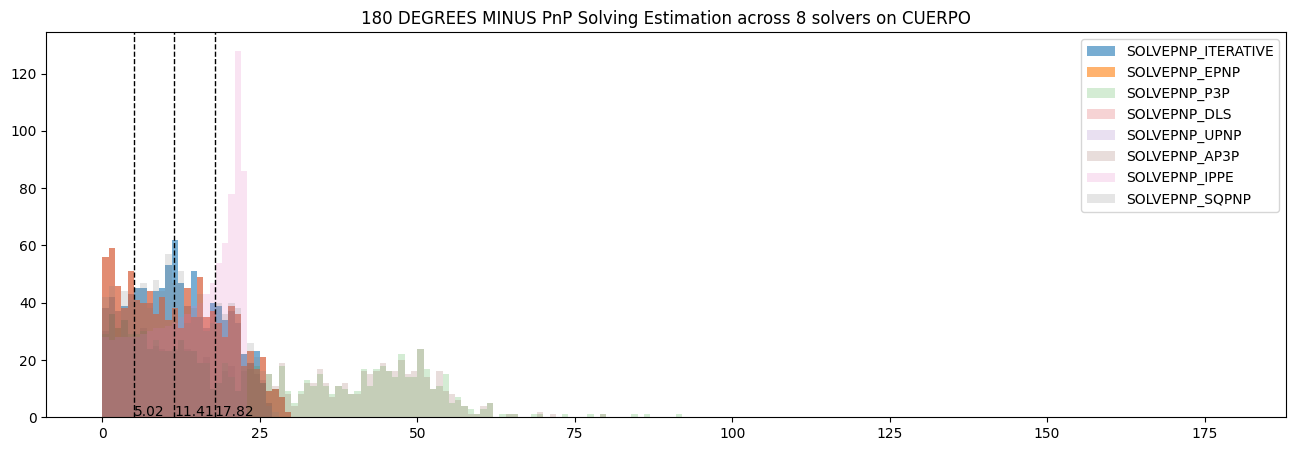

In [77]:
# whole dataset:
import json
import numpy as np
import cv2 as cv
import cv2
import glob
import tqdm
import personal_TEST
import importlib
import numpy as np
from scipy.spatial.transform import Rotation
import itertools
multipliers = np.array(list(itertools.product([1, -1], repeat=3)))
permutations = np.array(list(itertools.permutations([0, 1, 2])))

# angular_errors = []
# l2_pts_errors = []

p = np.array([2, 1, 0])
m = np.array([-1, 1, 1])
json_files = glob.glob('/Users/dk/Documents.nosync/msc-project/pnp/data/cuerpo_with_pnp_1/data/*.json')

# for p in tqdm.tqdm(permutations):
#     for m in multipliers:
        
angular_errors = []
l2_pts_errors = []

for json_file in tqdm.tqdm(json_files[:1000]):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]

    shuffled_indices = np.random.permutation(len(observed_pts))
    # observed_pts = observed_pts[shuffled_indices]


    blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['attitude_rot']        # this is a quaternion - needs to be converted to a rotation matrix

    r = Rotation.from_quat(np.array(R))
    R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation error
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_DLS', 
        'SOLVEPNP_UPNP', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_IPPE', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        if flag == 'SOLVEPNP_P3P' or flag == 'SOLVEPNP_AP3P' or flag == 'SOLVEPNP_IPPE':
            success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
        else:
            success, rotation_vector, translation_vector = cv.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
        
        
        if not success:             rotation_matrix = np.eye(3)
        else:                       rotation_matrix, _ = cv2.Rodrigues(rotation_vector)


        # print(rotation_matrix)
        # print angular error between estimate and ground truth
        rot = np.linalg.solve(R, rotation_matrix.T)
        # print(np.trace(rot))
        if np.isclose(np.trace(rot), -1): trace = -1
        else: trace = np.trace(rot)
        rot_error = 180 - np.arccos(np.clip((trace-1)/2, -1, 1))*180/np.pi
        # print(f'flag: {flag}, rot_error: {rot_error}')
        ang_error_each.append(rot_error)
    
    angular_errors.append(ang_error_each)


import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
try:

    # define plt bins
    bins = np.arange(0, 180, 1)

    plt.figure(figsize=(16,5))
    plt.title('180 DEGREES MINUS PnP Solving Estimation across 8 solvers on CUERPO'.format(p, m))
    plt.hist(angular_errors[:,0], bins=bins, label='SOLVEPNP_ITERATIVE', alpha=0.6);
    plt.hist(angular_errors[:,1], bins=bins, label='SOLVEPNP_EPNP', alpha=0.6);
    plt.hist(angular_errors[:,2], bins=bins, label='SOLVEPNP_P3P', alpha=0.2);
    plt.hist(angular_errors[:,3], bins=bins, label='SOLVEPNP_DLS', alpha=0.2);
    plt.hist(angular_errors[:,4], bins=bins, label='SOLVEPNP_UPNP', alpha=0.2);
    plt.hist(angular_errors[:,5], bins=bins, label='SOLVEPNP_AP3P', alpha=0.2);
    plt.hist(angular_errors[:,6], bins=bins, label='SOLVEPNP_IPPE', alpha=0.2);
    plt.hist(angular_errors[:,7], bins=bins, label='SOLVEPNP_SQPNP', alpha=0.2);

    # get quartiles of best one
    q1, q2, q3 = np.quantile(angular_errors[:,-5], [0.25, 0.5, 0.75])
    plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
    plt.text(q1, .5, f'{q1:.2f}')
    plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
    plt.text(q2, .5, f'{q2:.2f}')
    plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
    plt.text(q3, .5, f'{q3:.2f}')
    plt.legend()
    plt.show()
except: pass


In [78]:
world_keypoints = [
        [
            0.5285135507583618,
            3.9575204849243164,
            -0.17695434391498566
        ],
        [
            -0.6007072329521179,
            1.6536147594451904,
            -0.17696230113506317
        ],
        [
            1.0027564764022827,
            0.7642956376075745,
            -0.17695918679237366
        ],
        [
            -0.33425694704055786,
            3.2653729915618896,
            -0.1769549697637558
        ],
        [
            -0.9937456250190735,
            -1.5950886011123657,
            0.011871427297592163
        ],
        [
            0.1748146414756775,
            1.725520372390747,
            -0.18683718144893646
        ],
        [
            0.2951548099517822,
            3.392299175262451,
            -0.1868320107460022
        ],
        [
            -0.33500730991363525,
            -1.100817322731018,
            -0.1769627183675766
        ],
        [
            0.306401789188385,
            -1.5755712985992432,
            -0.17696164548397064
        ],
        [
            -0.7736372947692871,
            -0.45953044295310974,
            -0.17695413529872894
        ],
        [
            -1.2592847347259521,
            -1.6955063343048096,
            0.30395710468292236
        ]]

In [80]:
world_keypoints.reshape(-1)

array([ 0.52851355,  3.95752048, -0.17695434, -0.60070723,  1.65361476,
       -0.1769623 ,  1.00275648,  0.76429564, -0.17695919, -0.33425695,
        3.26537299, -0.17695497, -0.99374563, -1.5950886 ,  0.01187143,
        0.17481464,  1.72552037, -0.18683718,  0.29515481,  3.39229918,
       -0.18683201, -0.33500731, -1.10081732, -0.17696272,  0.30640179,
       -1.5755713 , -0.17696165, -0.77363729, -0.45953044, -0.17695414,
       -1.25928473, -1.69550633,  0.3039571 ])

In [79]:
world_keypoints = np.array(world_keypoints)
world_keypoints.shape


(11, 3)

In [47]:
print(np.quantile(angular_errors[:,-4], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,-5], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,-7], [0.25, 0.5, 0.75]))

[ 5.01606017 11.40513994 17.81730407]
[ 5.01606017 11.40513994 17.81730407]
[ 5.01606017 11.40513994 17.81730407]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


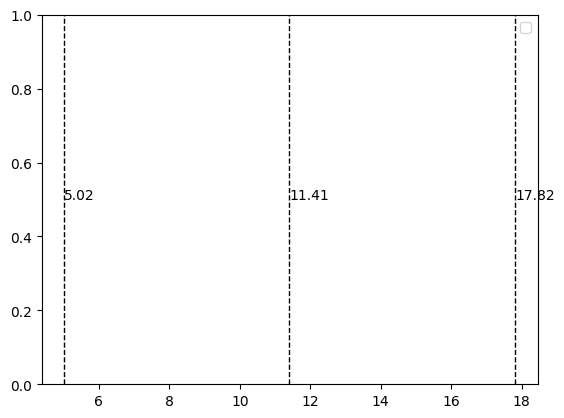

In [33]:
# get quartiles of best one
q1, q2, q3 = np.quantile(angular_errors[:,4], [0.25, 0.5, 0.75])
plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
plt.text(q1, .5, f'{q1:.2f}')
plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
plt.text(q2, .5, f'{q2:.2f}')
plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
plt.text(q3, .5, f'{q3:.2f}')
plt.legend()
plt.show()

  2%|▎         | 25/1000 [00:00<00:03, 246.37it/s]

100%|██████████| 1000/1000 [00:04<00:00, 243.94it/s]


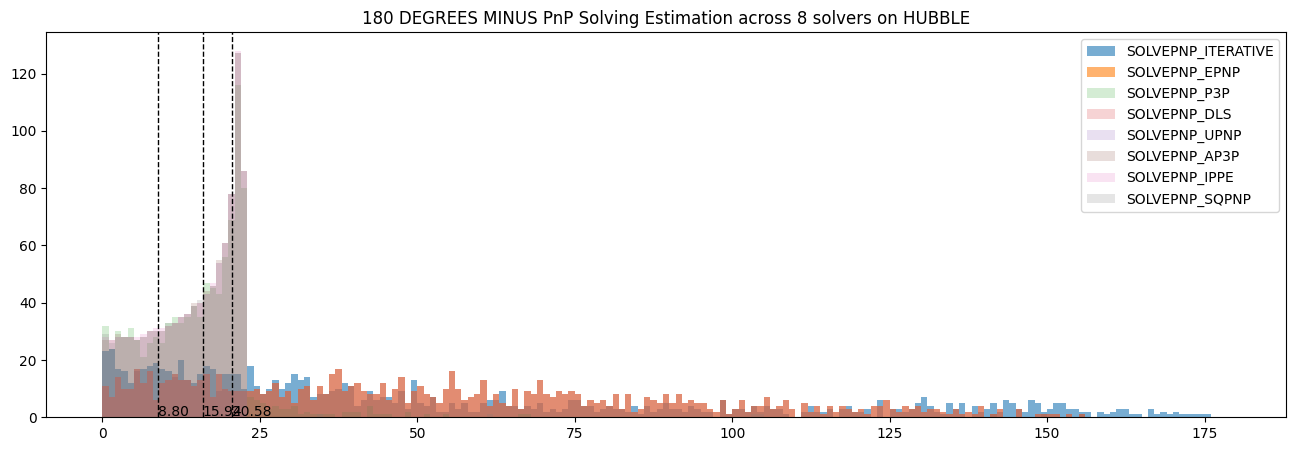

In [48]:
# whole dataset:
import json
import numpy as np
import cv2 as cv
import cv2
import glob
import tqdm
import personal_TEST
import importlib
import numpy as np
from scipy.spatial.transform import Rotation
import itertools
multipliers = np.array(list(itertools.product([1, -1], repeat=3)))
permutations = np.array(list(itertools.permutations([0, 1, 2])))

# angular_errors = []
# l2_pts_errors = []

p = np.array([2, 1, 0])
m = np.array([-1, 1, 1])
json_files = glob.glob('/Users/dk/Documents.nosync/msc-project/pnp/data/hubble_with_pnp_1_20keypoints/data/*.json')

# for p in tqdm.tqdm(permutations):
#     for m in multipliers:
        
angular_errors = []
l2_pts_errors = []

for json_file in tqdm.tqdm(json_files[:1000]):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]


    shuffled_indices = np.random.permutation(len(observed_pts))
    # observed_pts = observed_pts[shuffled_indices]


    blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['attitude_rot']        # this is a quaternion - needs to be converted to a rotation matrix

    r = Rotation.from_quat(np.array(R))
    R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation error
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_DLS', 
        'SOLVEPNP_UPNP', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_IPPE', 
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        try:
            if flag == 'SOLVEPNP_P3P' or flag == 'SOLVEPNP_AP3P' or flag == 'SOLVEPNP_IPPE':
                success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], Xcam[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
            else:
                success, rotation_vector, translation_vector = cv.solvePnP(Xworld, Xcam, A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
        except:
            rotation_matrix = np.eye(3)
        
        if not success:             rotation_matrix = np.eye(3)
        else:                       rotation_matrix, _ = cv2.Rodrigues(rotation_vector)


        # print(rotation_matrix)
        # print angular error between estimate and ground truth
        rot = np.linalg.solve(R, rotation_matrix.T)
        # print(np.trace(rot))
        if np.isclose(np.trace(rot), -1): trace = -1
        else: trace = np.trace(rot)
        rot_error = 180 - np.arccos(np.clip((trace-1)/2, -1, 1))*180/np.pi
        # print(f'flag: {flag}, rot_error: {rot_error}')
        ang_error_each.append(rot_error)
    
    angular_errors.append(ang_error_each)


import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
try:

    # define plt bins
    bins = np.arange(0, 180, 1)

    plt.figure(figsize=(16,5))
    plt.title('180 DEGREES MINUS PnP Solving Estimation across 8 solvers on HUBBLE'.format(p, m))
    plt.hist(angular_errors[:,0], bins=bins, label='SOLVEPNP_ITERATIVE', alpha=0.6);
    plt.hist(angular_errors[:,1], bins=bins, label='SOLVEPNP_EPNP', alpha=0.6);
    plt.hist(angular_errors[:,2], bins=bins, label='SOLVEPNP_P3P', alpha=0.2);
    plt.hist(angular_errors[:,3], bins=bins, label='SOLVEPNP_DLS', alpha=0.2);
    plt.hist(angular_errors[:,4], bins=bins, label='SOLVEPNP_UPNP', alpha=0.2);
    plt.hist(angular_errors[:,5], bins=bins, label='SOLVEPNP_AP3P', alpha=0.2);
    plt.hist(angular_errors[:,6], bins=bins, label='SOLVEPNP_IPPE', alpha=0.2);
    plt.hist(angular_errors[:,7], bins=bins, label='SOLVEPNP_SQPNP', alpha=0.2);

    # get quartiles of best one
    q1, q2, q3 = np.quantile(angular_errors[:,-2], [0.25, 0.5, 0.75])
    plt.axvline(q1, color='k', linestyle='dashed', linewidth=1)
    plt.text(q1, .5, f'{q1:.2f}')
    plt.axvline(q2, color='k', linestyle='dashed', linewidth=1)
    plt.text(q2, .5, f'{q2:.2f}')
    plt.axvline(q3, color='k', linestyle='dashed', linewidth=1)
    plt.text(q3, .5, f'{q3:.2f}')
    plt.legend()
    plt.show()
except: pass


In [49]:
print(np.quantile(angular_errors[:,0], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,1], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,2], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,3], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,4], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,5], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,6], [0.25, 0.5, 0.75]))
print(np.quantile(angular_errors[:,7], [0.25, 0.5, 0.75]))



[14.82582642 34.07663778 80.70348048]
[21.05791221 47.16234008 77.31258236]
[ 9.1874241  16.33813138 21.09000255]
[21.05791221 47.16234008 77.31258236]
[21.05791221 47.16234008 77.31258236]
[ 8.89903234 16.0059926  20.60446173]
[ 8.79944831 15.93530081 20.57938606]
[ 8.89903234 15.98348426 20.61272061]


In [24]:
plt.close('all')

100%|██████████| 1000/1000 [00:02<00:00, 451.37it/s]


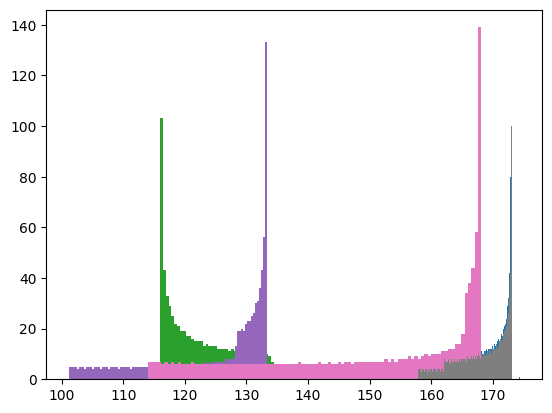

In [123]:
# whole dataset:
import json
import numpy as np
import glob
import tqdm
import personal_TEST
import importlib
import numpy as np
from scipy.spatial.transform import Rotation


angular_errors = []
l2_pts_errors = []

# p = np.array([0, 2, 1])
# m = np.array([-1, -1, 1])

json_files = glob.glob('/Users/dk/Documents.nosync/msc-project/pnp/data/cuerpo_with_pnp_1/data/*.json')

for json_file in tqdm.tqdm(json_files[:1000]):
    example_data = json.loads(open(json_file).read())
    # example_data = json.loads(open('/Users/dk/Documents.nosync/msc-project/pnp/data/starlink_with_pnp_1/data/meta_3.json').read())

    base_world_pts = np.array(example_data['world_keypoints'])
    # base_world_pts[:, [0, 1, 2]] = base_world_pts[:, list(p)]
    # base_world_pts = base_world_pts*m

    observed_pts   = np.array(example_data['sensor_keypoints'])
    # observed_pts[:, [0, 1]] = observed_pts[:, [1, 0]]


    shuffled_indices = np.random.permutation(len(observed_pts))
    # observed_pts = observed_pts[shuffled_indices]


    blender_K = np.array(example_data['intrinsic_matrix'])
    # K = np.array([[blender_K[1,1]/blender_K[0,0], 0, 0], [0, 1, 0], [0, 0, 1]])
    K = np.eye(3)
    R = example_data['attitude_rot']        # this is a quaternion - needs to be converted to a rotation matrix

    r = Rotation.from_quat(np.array(R))
    R = r.as_matrix()

    K = np.hstack((K, np.zeros((3,1))))
    Xworld = np.array(base_world_pts)
    Xcam = np.array(observed_pts)
    A = np.array(K)

    # load points
    # ET = personal_TEST.EPnPTest()
    # ET.load_custom_points_noplot(Xworld, Xcam, A)

    # run EPnP
    # success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], A[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
    
    ########  ---------------------------------------rotation error
    all_flags = [
        'SOLVEPNP_ITERATIVE', 
        'SOLVEPNP_EPNP', 
        'SOLVEPNP_P3P', 
        'SOLVEPNP_DLS', 
        'SOLVEPNP_UPNP', 
        'SOLVEPNP_AP3P', 
        'SOLVEPNP_IPPE',    # plane-based?
        'SOLVEPNP_SQPNP'
    ]
    # rotation_matrix_gt = np.array([[0.707, -0.707, 0], [0.707, 0.707, 0], [0, 0, 1]])

    ang_error_each = []
    for flag in all_flags:
        try:
            success, rotation_vector, translation_vector = cv.solvePnP(Xworld[:4], uv_rot_cube[:4], K[:3,:3], distCoeffs=np.array([0,0,0,0,0], np.double), flags=cv.__dict__[flag])
            rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
        except: 
            pass

        # print(rotation_matrix)
        # print angular error between estimate and ground truth
        rot = np.linalg.solve(R, rotation_matrix.T)
        # print(np.trace(rot))
        if np.isclose(np.trace(rot), -1): trace = -1
        else: trace = np.trace(rot)
        rot_error = np.arccos(np.clip((trace-1)/2, -1, 1))*180/np.pi
        # print(f'flag: {flag}, rot_error: {rot_error}')
        ang_error_each.append(rot_error)
    
    angular_errors.append(ang_error_each)


import matplotlib.pyplot as plt
angular_errors = np.array(angular_errors)
plt.hist(angular_errors[:,0], bins=100);
plt.hist(angular_errors[:,1], bins=100);
plt.hist(angular_errors[:,2], bins=100);
plt.hist(angular_errors[:,3], bins=100);
plt.hist(angular_errors[:,4], bins=100);
plt.hist(angular_errors[:,5], bins=100);
plt.hist(angular_errors[:,6], bins=100);
plt.hist(angular_errors[:,7], bins=100);
